<a href="https://colab.research.google.com/github/ANKITSINGH72/Face_recognition/blob/main/MELE_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip /content/Dataset.zip -d /content/

Archive:  /content/Dataset.zip
   creating: /content/Dataset/test/
   creating: /content/Dataset/test/Angelina Jolie/
  inflating: /content/Dataset/test/Angelina Jolie/080_e998ab00.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/081_12fb31ec.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/082_047778bb.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/083_bdada1e2.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/084_da751ddd.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/085_f579db33.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/086_f2c730f3.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/087_f325890f.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/088_029ffc54.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/089_33e36564.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/090_da55509f.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/091_b5b4a62f.jpg  
  inflating: /content/Dataset/test/Angelina Jolie/092_

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
# Define data directories
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

In [6]:
# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Preprocess and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Adding validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # Set as validation data

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [7]:
# Plot some images from the train generator
def plot_images_from_generator(generator, num_images):
    images, labels = next(generator)
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()

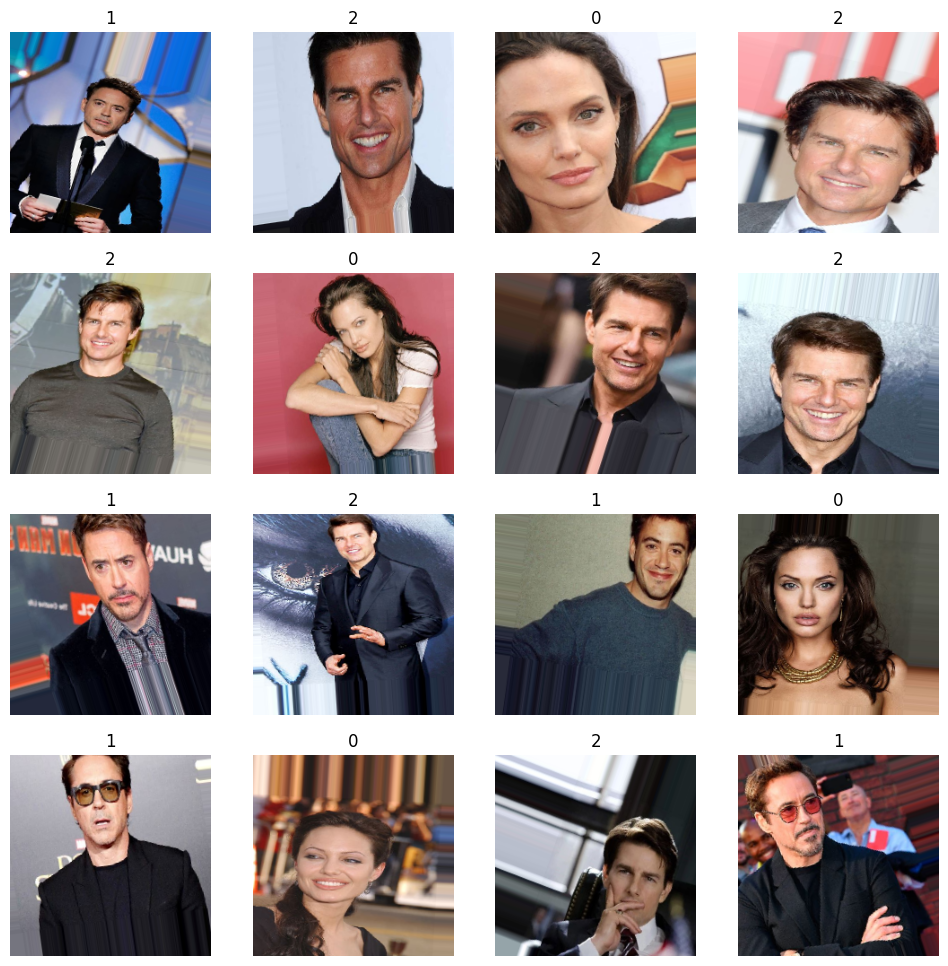

In [8]:
plot_images_from_generator(train_generator, 16)

In [9]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/10
6/6 [==============================] - 16s 894ms/step - loss: 11.3831 - accuracy: 0.3646 - val_loss: 5.8102 - val_accuracy: 0.5625
Epoch 2/10
6/6 [==============================] - 3s 548ms/step - loss: 3.4511 - accuracy: 0.4427 - val_loss: 2.2873 - val_accuracy: 0.3750
Epoch 3/10
6/6 [==============================] - 3s 541ms/step - loss: 1.6609 - accuracy: 0.4740 - val_loss: 0.4093 - val_accuracy: 0.8750
Epoch 4/10
6/6 [==============================] - 4s 538ms/step - loss: 0.7269 - accuracy: 0.6562 - val_loss: 0.5895 - val_accuracy: 0.7188
Epoch 5/10
6/6 [==============================] - 3s 561ms/step - loss: 0.5135 - accuracy: 0.7500 - val_loss: 0.4198 - val_accuracy: 0.8125
Epoch 6/10
6/6 [==============================] - 5s 948ms/step - loss: 0.4769 - accuracy: 0.8229 - val_loss: 0.4908 - val_accuracy: 0.8125
Epoch 7/10
6/6 [==============================] - 3s 532ms/step - loss: 0.3347 - accuracy: 0.8750 - val_loss: 0.2131 - val_accuracy: 0.9375
Epoch 8/10
6/6 [==

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

2/2 [==============================] - 6s 6s/step - loss: 0.3875 - accuracy: 0.8254
Test loss: 0.38749852776527405
Test accuracy: 0.8253968358039856


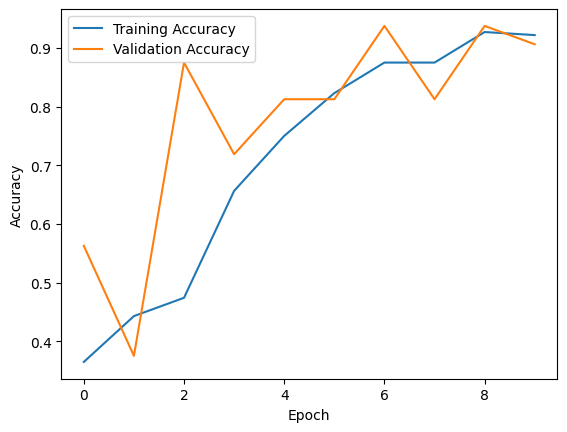

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

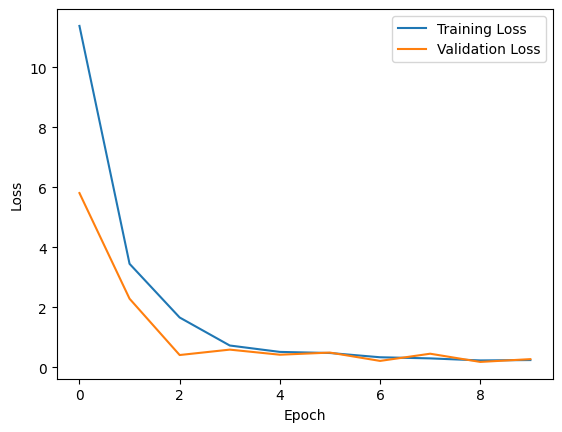

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 205ms/step
Classification Report:
                  precision    recall  f1-score   support

  Angelina Jolie       0.94      0.81      0.87        21
Robert Downey Jr       0.70      0.90      0.79        21
      Tom Cruise       0.89      0.76      0.82        21

        accuracy                           0.83        63
       macro avg       0.85      0.83      0.83        63
    weighted avg       0.85      0.83      0.83        63

Confusion Matrix:


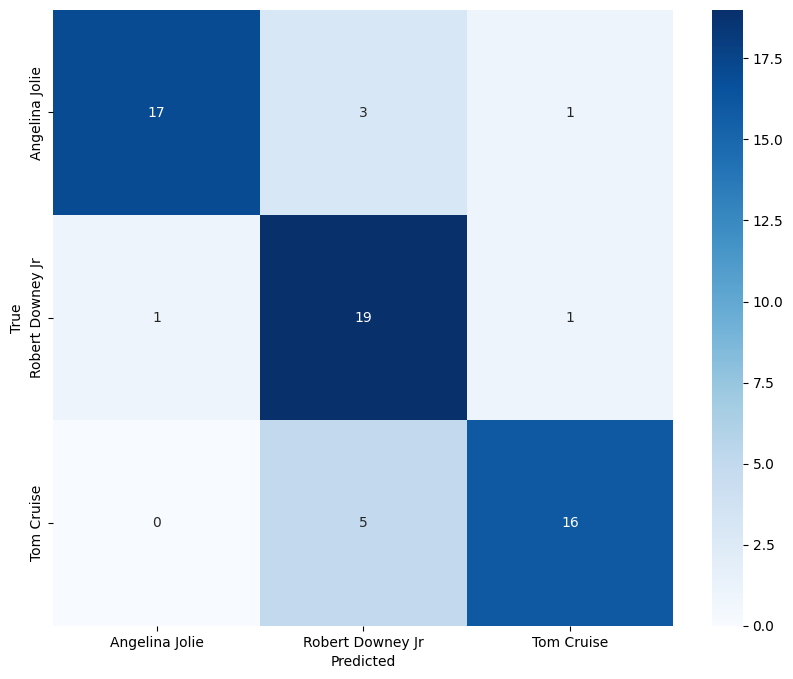

In [16]:
# Make predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(train_generator.class_indices.keys()), yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


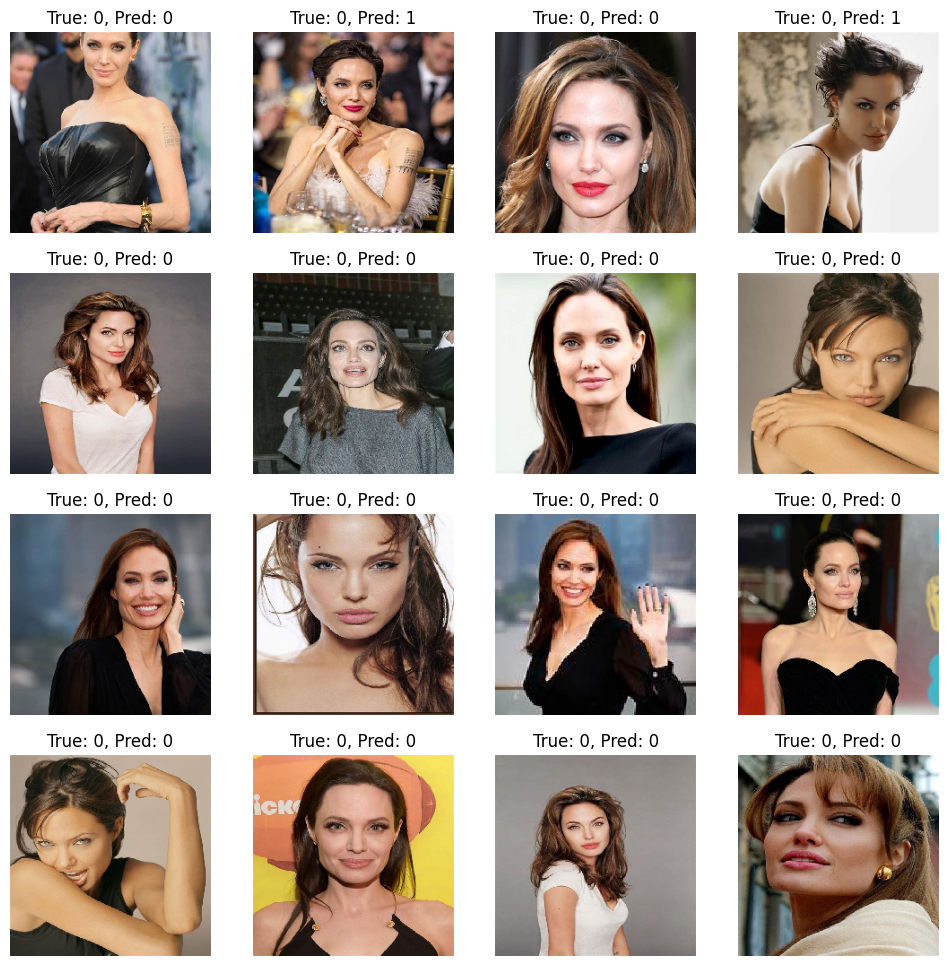

In [17]:
# Visualize some test predictions
def plot_test_predictions(generator, predictions, num_images):
    images, labels = next(generator)
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = np.argmax(labels[i])
        pred_label = predictions[i]
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
    plt.show()

plot_test_predictions(test_generator, y_pred, 16)